<a href="https://colab.research.google.com/github/roesta07/Notes/blob/main/MCMC_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Imports and utility functions
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install pymc3==3.8
    !pip install --upgrade daft
    !pip install --upgrade theano
    !pip install causalgraphicalmodels
    !pip install watermark
    !pip install arviz==0.11 --no-dependencies
    !pip install netCDF4
    !pip install xarray

     |████████████████████████████████| 911kB 5.5MB/s 
     |████████████████████████████████| 1.6MB 13.7MB/s 
     |████████████████████████████████| 768kB 16.2MB/s 
     |████████████████████████████████| 4.7MB 37.0MB/s 
     |████████████████████████████████| 317kB 38.6MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
  Found existing installation: daft 0.0.4
    Uninstalling daft-0.0.4:
      Successfully uninstalled daft-0.0.4
Requirement already up-to-date: theano in /usr/local/lib/python3.7/dist-packages (1.0.5)
  Found existing installation: importlib-metadata 3.7.2
    Uninstalling importlib-metadata-3.7.2:
      Successfully uninstalled importlib-metadata-3.7.2
     |████████████████████████████████| 1.6MB 5.8MB/s 
  Found existing installation: arviz 0.11.2
    Uninstalling arviz-0.11.2:
  

In [4]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import daft
from theano import theano
from scipy.special import expit as logistic

from scipy.interpolate import griddata
from causalgraphicalmodels import CausalGraphicalModel

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
# %load_ext watermark
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

# Approximation of Unknown Mean and Sigma of Normal Distribution
A glimpse of how MCMC sampler works; a Note to self<br>
*keywords: Python,Metropolis-Hasting*

I have had always used some high level algorithm to sample for posterior values for my parameters since the begining of where I can recall; but everytime I use them I have always thought how would such samplers be so smart to give such plausable values and now I think I may have got closer to the answer.


#Assumption about data
$P(data)\sim Normal(mu,sigma)$<br>


In [8]:
# Assuming data generates from some process which are distributed Normally;
# We are trying to estimate the parameters for Normal Distribution i.e Mu and sigma 
data=stats.norm().rvs(5)
data

array([-0.56543934, -1.9258688 ,  0.26178995, -0.16223459, -1.87358894])

#Grid Appromiximation vs MCMC
Understanding MCMC with Contrast

It is important understand that how a model assigns plausability to parameter values, here both methods uses the same underlying model assumptions and just bay's formula to compute plausability to parameter values but the differece is that in Grid Appromiximation plausibility are assigned to each and every value that lies in a grid.
We can already see some problem with this method; first as we start adding more parameters the grid becomes large and second if the parameters have large grid scales.This problems can be computationally heavy as there are infinite numbers between just 0 and 1.

But lets see both ways
###Grid Appromiximation

In [9]:
## lets first use grid-appromixation for both mu and sigma
mu_x=np.linspace(-5,5,500)
sigma_x=np.linspace(0,5,500)
## this is the grid we are serching for
points = np.mgrid[-5:5:0.05, 1:5:0.05].reshape(2,-1).T
## calculate posterior
prior_mu=stats.norm.logpdf(points[:,0],loc=0,scale=10)
prior_sigma=stats.uniform.logpdf(points[:,1],1,5)
liklihood=[ sum(stats.norm.logpdf(data,loc=points[:,0][i],scale=points[:,1][i]) )
            for i in range(len(points))]
unnormalized_log_posterior=(prior_mu+prior_sigma+liklihood)
unnormalized_posterior = np.exp(unnormalized_log_posterior - max(unnormalized_log_posterior))
normalized_posterior=unnormalized_posterior/unnormalized_posterior.sum()


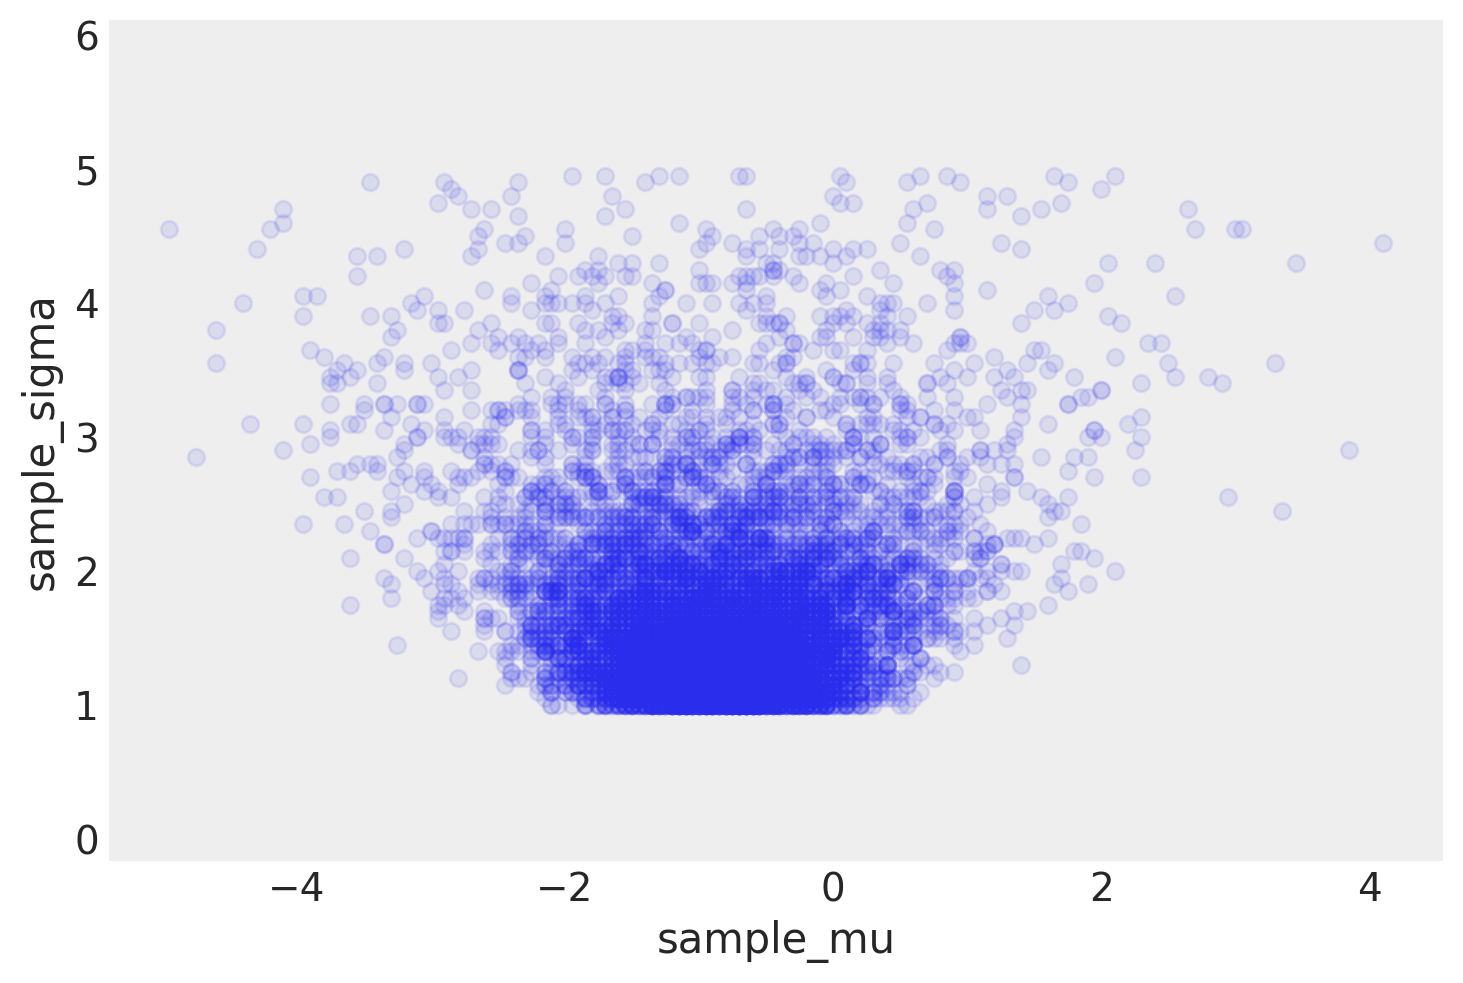

In [10]:
## Sampling and Plotting
sample_index=np.random.choice(range(len(points)),p=normalized_posterior,replace=True,size=10000)
sample_mu=points[:,0][sample_index]
sample_sigma=points[:,1][sample_index]
fig,ax=plt.subplots()
ax.plot(sample_mu,sample_sigma,'o',alpha=0.1)
ax.axis("equal")
ax.grid(False)
ax.set_xlabel("sample_mu")
ax.set_ylabel("sample_sigma");

# Approximation using MCMC

In [ ]:
sample=500
trace=np.array([np.zeros(sample),np.zeros(sample)]).reshape(sample,2)
mu_current = 1
sigma_current= 5
width_size=0.5
def sampler(mu_current = 1,sigma_current= 5,width_size=0.5,sample=4):
  trace=np.array([np.zeros(sample),np.zeros(sample)]).reshape(sample,2)
  for i in range(sample):
    mu_proposal = stats.norm(mu_current, width_size).rvs()
    sigma_proposal=stats.uniform(1,sigma_current).rvs()


    ##priors mu
    prior_mu_current=stats.norm(0,10).pdf(mu_current)
    prior_mu_proposal=stats.norm(0,10).pdf(mu_proposal)
 
    ## priors sigma
    prior_sigma_current=stats.uniform(1,5).pdf(sigma_current)
    prior_sigma_proposal=stats.uniform(1,5).pdf(sigma_proposal)

    ##liklihood
    liklihood_current=stats.norm(mu_current,sigma_current).pdf(data).prod()
    liklihood_proposal=stats.norm(mu_proposal,sigma_proposal).pdf(data).prod()

    p_current=prior_mu_current*prior_sigma_current*liklihood_current
    p_proposal=prior_mu_proposal*prior_sigma_proposal*liklihood_proposal

    ##accept or reject
    p_accept = p_proposal / p_current

    # Usually would include prior probability, which we neglect here for simplicity
    accept = np.random.rand() < p_accept

    if accept:
        # Update position
        mu_current = mu_proposal
        sigma_current=sigma_proposal
    trace[:,0][i]=mu_current
    trace[:,1][i]=sigma_current
  return trace


In [ ]:
## Samples
trace_1=sampler(sample=500)
mu_mcmc_samples=trace_1[:,0]
sigma_mcmc_samples=trace_1[:,1]

## Diagnosing Parameter Values

[Text(0.5, 0, 'Sample Index( no of samples)'), Text(0.5, 1.0, 'Trace Sigma')]

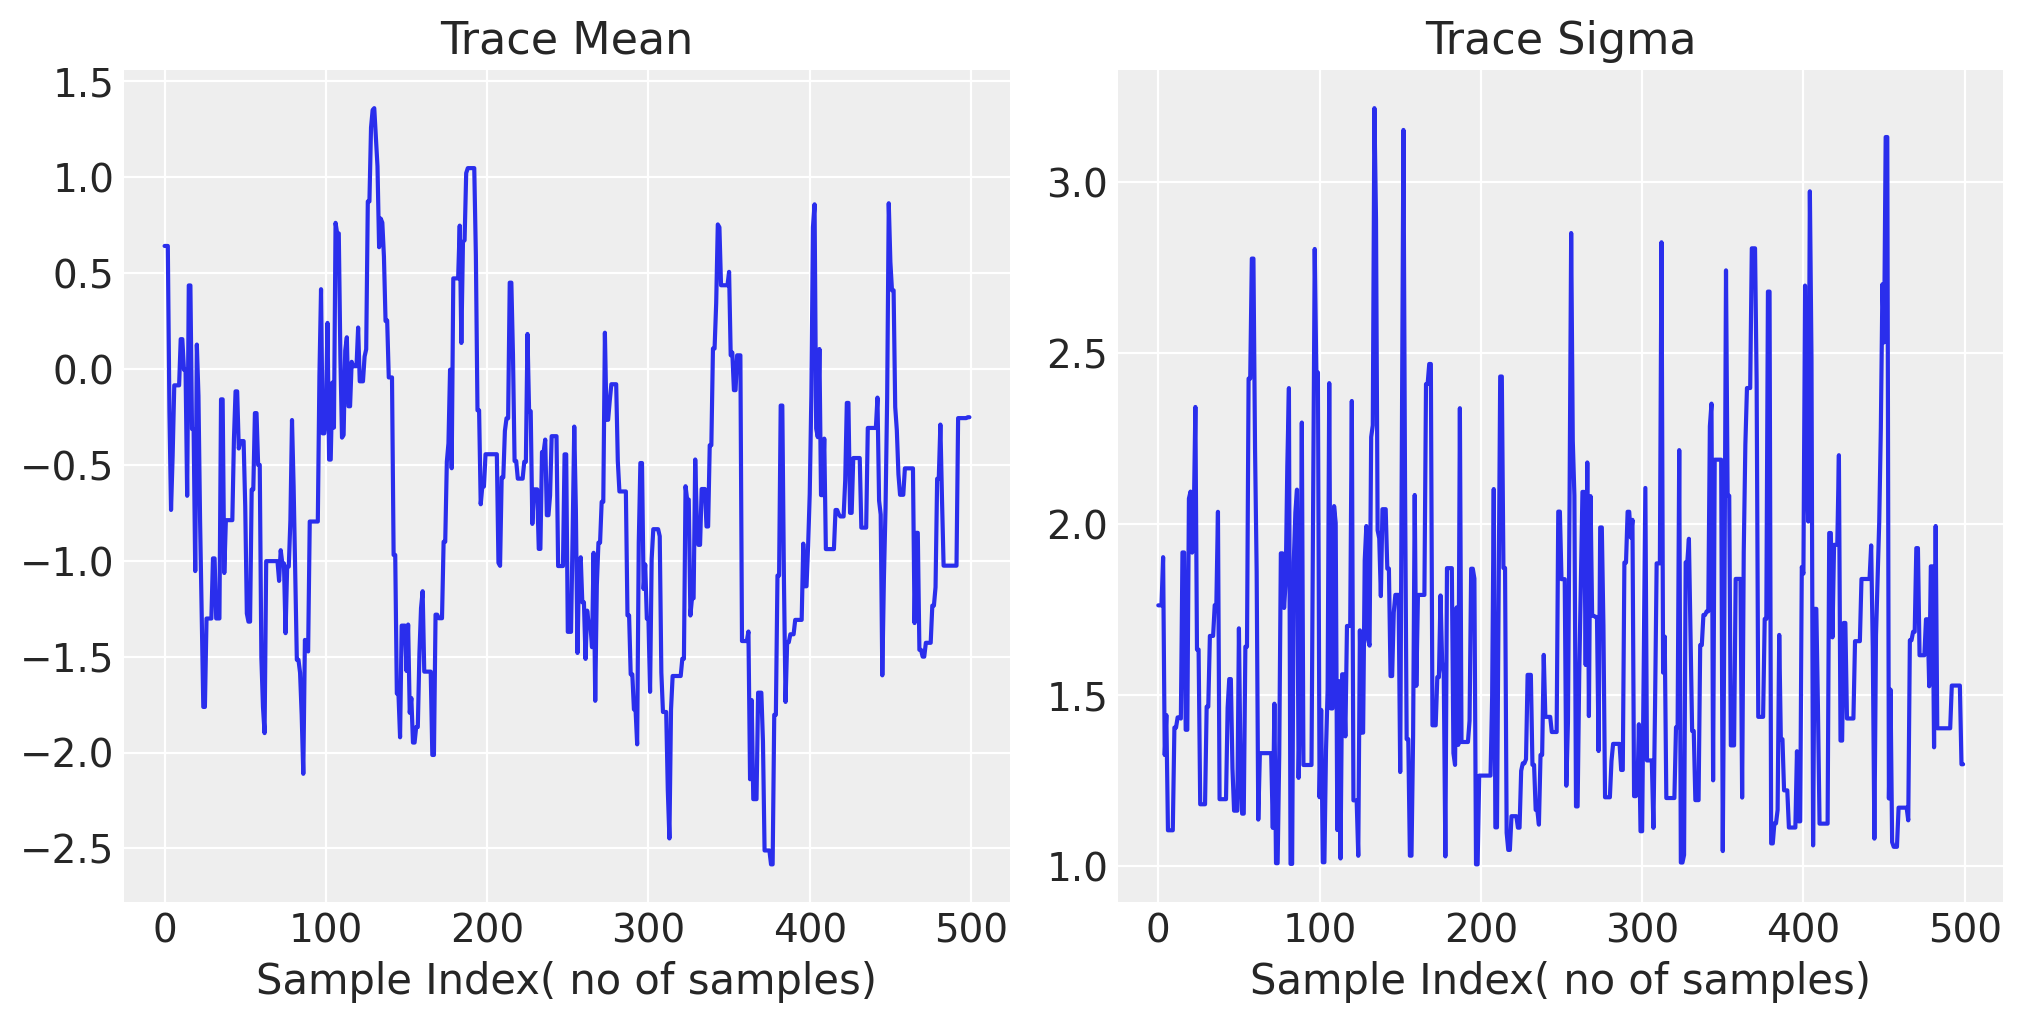

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].plot(mu_mcmc_samples)
axs[1].plot(sigma_mcmc_samples)

axs[0].set(title='Trace Mean',xlabel='Sample Index( no of samples)')
axs[1].set(title='Trace Sigma',xlabel='Sample Index( no of samples)')

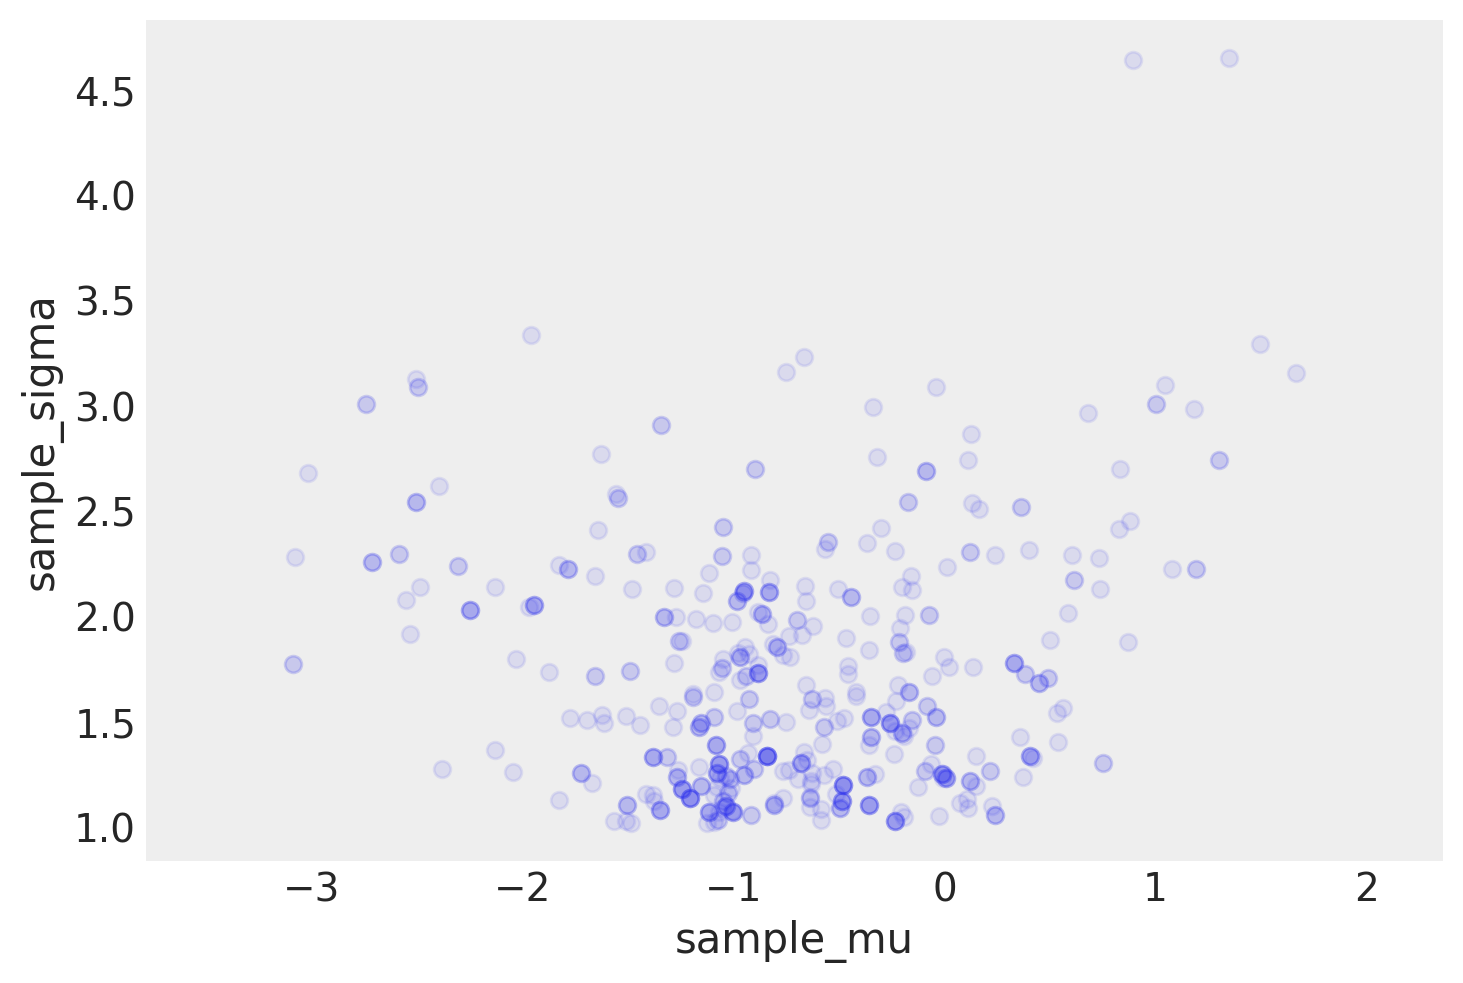

In [ ]:
fig,ax=plt.subplots()
ax.plot(mu_mcmc_samples,sigma_mcmc_samples,'o',alpha=0.1)
ax.axis("equal")
ax.grid(False)
ax.set_xlabel("sample_mu")
ax.set_ylabel("sample_sigma");

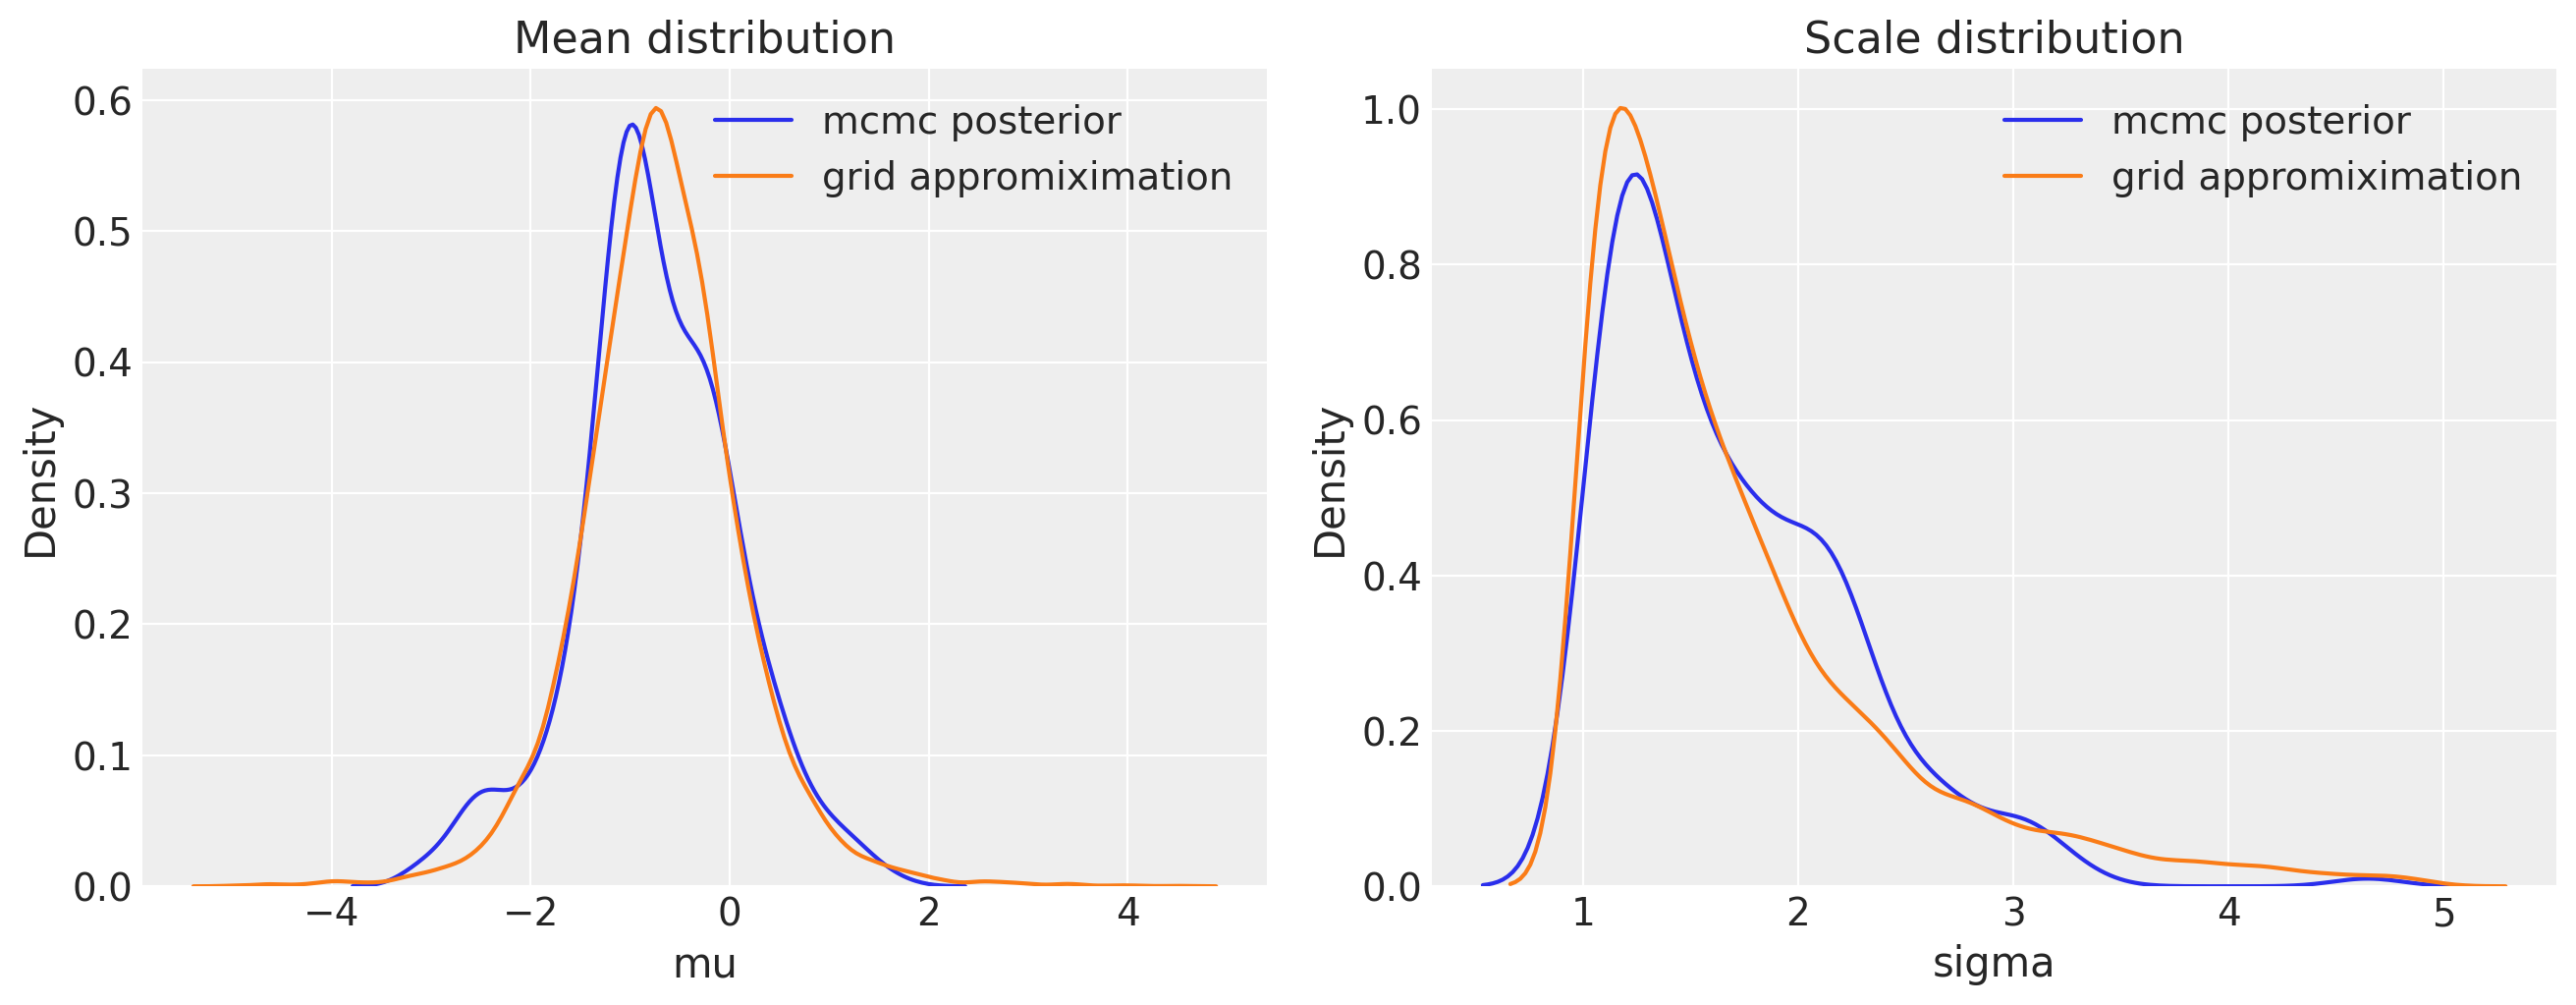

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(13,5))
sns.kdeplot(mu_mcmc_samples, ax=ax[0], label='mcmc posterior')
sns.kdeplot(sample_mu,ax=ax[0],label='grid appromiximation')
sns.kdeplot(sigma_mcmc_samples, ax=ax[1], label='mcmc posterior')
sns.kdeplot(sample_sigma,ax=ax[1],label='grid appromiximation')

ax[0].set(xlabel='mu',title="Mean distribution")
ax[1].set(xlabel='sigma',title="Scale distribution")
ax[0].legend()
ax[1].legend()